In [19]:
import os
import numpy as np
import scipy
from scipy import integrate
import matplotlib.pyplot as plt
# import camb
# from camb import model
from jupyterthemes import jtplot
import math
import time
import h5py
import sys
# moments_path = os.path.realpath(os.path.join(os.getcwd(), '../Moments_analysis/'))
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/Moments_analysis')
sys.path.insert(0, '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/')
import h5py as h5
import healpy as hp
import pickle
import copy
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol = 2)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)#, encoding='latin1')

jtplot.reset()
from tqdm import tqdm


def save_unique_combs(nsm, nzbins):
    id_corr2_unique = []
    for i in range(nsm):
        for j in range(nsm):
            if i <= j:
                id_corr2_unique.append((i,j))

    id_kp2_unique = []
    for jz1 in range(nzbins):
        for jz2 in range(nzbins):
            if jz1 <= jz2:
                for i in range(nsm):
                    for j in range(nsm):
                        if i <= j:
                            id_kp2_unique.append((jz1, jz2, i, j))
    
    id_corr3_unique = []
    for i in range(nsm):
        for j in range(nsm):
            for k in range(nsm):
                if (k >= j and j >= i):
                    id_corr3_unique.append((i,j,k))
    
    id_kp3_unique = []
    for jz1 in range(nzbins):
        for jz2 in range(nzbins):
            for jz3 in range(nzbins):
                if (jz3 >= jz2 and jz2 >= jz1):
                    for i in range(nsm):
                        for j in range(nsm):
                            for k in range(nsm):
                                if (k >= j and j >= i):
                                    id_kp3_unique.append((jz1, jz2, jz3, i, j, k))

    return id_corr2_unique, id_kp2_unique, id_corr3_unique, id_kp3_unique






In [12]:
def rotate_map_approx(mask, rot_angles, flip=False, nside=2048):
    alpha, delta = hp.pix2ang(nside, np.arange(len(mask)))

    rot = hp.rotator.Rotator(rot=rot_angles, deg=True)
    rot_alpha, rot_delta = rot(alpha, delta)
    if not flip:
        rot_i = hp.ang2pix(nside, rot_alpha, rot_delta)
    else:
        rot_i = hp.ang2pix(nside, np.pi - rot_alpha, rot_delta)
    rot_map = np.copy(mask) * 0.
    rot_map[rot_i] = mask[np.arange(len(mask))]
    return rot_map



In [3]:
# # import matplotlib as mpl
# # mpl.rcParams['text.usetex'] = False
# import matplotlib.pyplot as plt
# plt.rcParams.update({
#     "text.usetex": False,
#     "font.family": "Helvetica"
# })
import healpy as hp
mask_sims0 = hp.read_map('/global/cfs/cdirs/lsst/www/shivamp/gen_mom/process_data/mask_sims.fits',verbose=False)
# hp.mollview(mask_sims)
nside = hp.npix2nside(len(mask_sims0))
mask_sims1 = rotate_map_approx(mask_sims0, [359, 359, 359], flip=False, nside=nside)
mask_sims2 = rotate_map_approx(mask_sims0, [45, 0, -90], flip=False, nside=nside)
mask_sims3 = rotate_map_approx(mask_sims0, [-90, 0, 0], flip=False, nside=nside)
# df = hp.read_map('/global/cfs/cdirs/des/mgatti/maps_shivam_mask_noise/temp_NEW_grid_fiducialcosmo_SC_k_Om=0.26_s8=0.84num=0A_IA=0.00e_IA=0.00rot=0/smoothed_maps/convergence_kE_bin_0_sm_8.2.fits')
# hp.mollview(df)
# mask_sims
# pl.show()



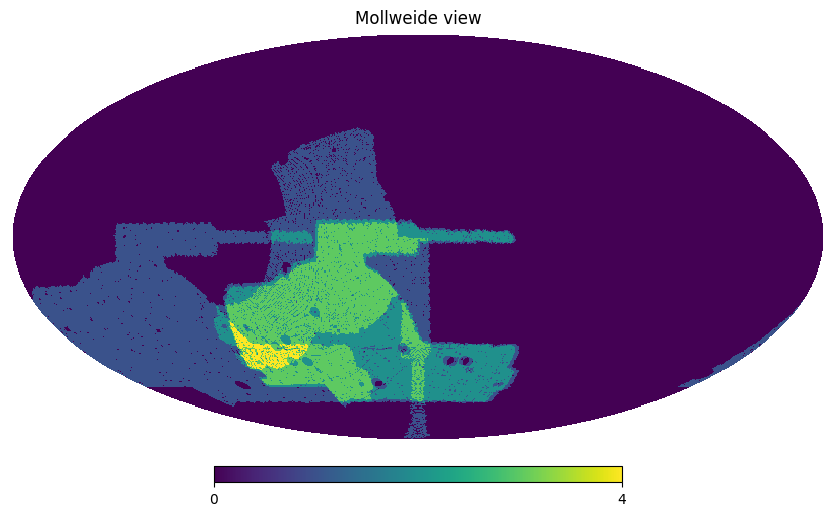

In [84]:
# hp.mollview(mask_sims0)
# hp.mollview(mask_sims1)
# hp.mollview(mask_sims2)
# hp.mollview(mask_sims3)

hp.mollview(mask_sims0 + mask_sims1 + mask_sims2 + mask_sims3)
# hp.mollview(mask_sims0 + mask_sims1 + mask_sims3)
# hp.mollview(mask_sims0 + mask_sims1)



In [8]:
ldir = '/global/cfs/cdirs/des/mgatti/maps_shivam_mask_noise/'

nsm = 8
nzbins = 4
_, id_kp2_unique, _, id_kp3_unique = save_unique_combs(nsm, nzbins)


kp2_all_data = []
kp3_all_data = []
from tqdm import tqdm
for js in tqdm(range(50)):
    for jr in range(4):
        
        # try:
        df = pk.load(open(ldir + 'moments_NEW_grid_fiducialcosmo_SC_k_Om=0.26_s8=0.84num=' + str(js) + 'A_IA=0.00e_IA=0.00rot=' + str(jr) + '.pkl','rb'))   

        kp2_all = []
        for jid_kp2 in range(len(id_kp2_unique)):
            jz1, jz2, i, j = id_kp2_unique[jid_kp2]
            key_jid = str(jz1) + '_' + str(jz2)
            kp2_allsm_jid = df.moments['kEkE'][key_jid] - df.moments['kNkN'][key_jid] 
            kp2_all.append(kp2_allsm_jid[i, j])
        kp2_all_data_jrjs = np.array(kp2_all)
        kp2_all_data.append(kp2_all_data_jrjs)


        kp3_all = []
        for jid_kp3 in (range(len(id_kp3_unique))):
            jz1, jz2, jz3, i, j, k = id_kp3_unique[jid_kp3]
            key_jid = str(jz1) + '_' + str(jz2) + '_' + str(jz3)

            kp3EE_allsm_jid = df.moments['kEkE'][key_jid]

            EEEdenoise = df.moments["kEkN"][key_jid]
            kp3_allsm_jid = ((kp3EE_allsm_jid - EEEdenoise - np.transpose(EEEdenoise, [2,1,0]) - np.transpose(EEEdenoise, [1,0,2]) ))
            # EEEdenoise = df.moments["kEkN"][key_jid]
            # kp3_allsm_jid = (kp3EE_allsm_jid)


            kp3_all.append(kp3_allsm_jid[i, j, k])
        kp3_all_data_jrjs = np.array(kp3_all)
        kp3_all_data.append(kp3_all_data_jrjs)
        # except:
        #     pass


kp3_all_data_orig = np.vstack(kp3_all_data)
kp2_all_data_orig = np.vstack(kp2_all_data)
print(kp3_all_data_orig.shape)
# kp3_all_data = kp3_all_data[0:20,:]
# kp2_all_data = kp2_all_data[0:20,:]

kp3_all_data_mean_orig = np.mean(kp3_all_data_orig, axis=0)
kp2_all_data_mean_orig = np.mean(kp2_all_data_orig, axis=0)
kp3_all_data_cov_orig = np.cov(kp3_all_data_orig.T)
kp2_all_data_cov_orig = np.cov(kp2_all_data_orig.T)



# sdir = '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/saveDVs/'
# # fname = sdir + 'pkdgrav_fid_wmask_sm5_SCkappa_all_fid'
# fname = sdir + 'theory_fid_wmask_sm5_SCkappa_all_fid'
# df_kappa_all = load_obj(fname)
# kappa2_all_fid = df_kappa_all['kp2']
# kappa3_all_fid = df_kappa_all['kp3']

# kp2_all_fid = []
# for jid_kp2 in range(len(id_kp2_unique)):
#     jz1, jz2, i, j = id_kp2_unique[jid_kp2]
#     kp2_all_fid.append(kappa2_all_fid[jz1, jz2, i, j])
# kp2_all_fid = np.array(kp2_all_fid)

# kp3_all_fid = []
# indsel_uneq = []
# indsel_uneq2 = []
# for jid_kp3 in range(len(id_kp3_unique)):
#     jz1, jz2, jz3, i, j, k = id_kp3_unique[jid_kp3]
#     if jz1==0 and jz2==3 and jz3==3:
#         indsel_uneq.append(jid_kp3)
#     if jz1==0 and jz2==0 and jz3==3:
#         indsel_uneq2.append(jid_kp3)
        
#     kp3_all_fid.append(kappa3_all_fid[jz1, jz2, jz3, i, j, k])
# kp3_all_fid = np.array(kp3_all_fid)


# saved = {'kp2_all_fid':kp2_all_fid, 'kp3_all_fid':kp3_all_fid, 'kp3_all_data':kp3_all_data, 'kp2_all_data':kp2_all_data}
# pk.dump(saved, open('fid_sim_measurements.pk','wb'))




  0%|          | 0/50 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/global/cfs/cdirs/des/mgatti/maps_shivam_mask_noise/moments_NEW_grid_fiducialcosmo_SC_k_Om=0.26_s8=0.84num=0A_IA=0.00e_IA=0.00rot=0.pkl'

In [5]:
# kp2_all_data
print(kp3_all_data_orig.shape)


(200, 2400)


In [20]:
ldir = '/global/cfs/cdirs/lsst/www/shivamp/gen_mom/measure_vfinal_cosmogrid/'

nsm = 8
nzbins = 4
_, id_kp2_unique, _, id_kp3_unique = save_unique_combs(nsm, nzbins)
# moments_measure_cosmogrid_jsim_29_rot_0_jnrealize_0.pkl.pkl

kp2_all_data = []
kp3_all_data = []
from tqdm import tqdm
for js in tqdm(range(200)):
    # for jr in [0,1,2,3]:
    for jr in [0,1,2,3,4,5,6,7]:
        try:
            df = pk.load(open(ldir + 'moments_measure_cosmogrid_jsim_' + str(js) + '_rot_' + str(jr) + '_jnrealize_0.pkl.pkl','rb'))   
            isfin = 1
        except:
            # try:
            #     df = pk.load(open(ldir + 'moments_measure_cosmogrid_jsim_' + str(js) + '_rot_' + str(jr) + '_jnrealize_0.pkl.pkl','rb'))   
            #     isfin = 1
            # except:
            isfin = 0
            pass
        
        if isfin:
            kp2_all = []
            for jid_kp2 in range(len(id_kp2_unique)):
                jz1, jz2, i, j = id_kp2_unique[jid_kp2]
                key_jid = str(jz1) + '_' + str(jz2)
                kp2_allsm_jid = df['kEkE'][key_jid] - df['kNkN'][key_jid] 
                kp2_all.append(kp2_allsm_jid[i, j])
            kp2_all_data_jrjs = np.array(kp2_all)
            kp2_all_data.append(kp2_all_data_jrjs)


            kp3_all = []
            for jid_kp3 in (range(len(id_kp3_unique))):
                jz1, jz2, jz3, i, j, k = id_kp3_unique[jid_kp3]
                key_jid = str(jz1) + '_' + str(jz2) + '_' + str(jz3)

                kp3EE_allsm_jid = df['kEkE'][key_jid]
                # try:
                # EEEdenoise = df["kEkN"][key_jid]
                # kp3_allsm_jid = ((kp3EE_allsm_jid - EEEdenoise - np.transpose(EEEdenoise, [2,1,0]) - np.transpose(EEEdenoise, [1,0,2]) ))
                # except:
                    # import pdb; pdb.set_trace()
                # EEEdenoise = df.moments["kEkN"][key_jid]
                kp3_allsm_jid = (kp3EE_allsm_jid)


                kp3_all.append(kp3_allsm_jid[i, j, k])
            kp3_all_data_jrjs = np.array(kp3_all)
            kp3_all_data.append(kp3_all_data_jrjs)
        # except:
            # pass


kp3_all_data = np.vstack(kp3_all_data)
kp2_all_data = np.vstack(kp2_all_data)
print(kp2_all_data.shape)
print(kp3_all_data.shape)
# kp3_all_data = kp3_all_data[0:20,:]
# kp2_all_data = kp2_all_data[0:20,:]

kp3_all_data_mean = np.mean(kp3_all_data, axis=0)
kp2_all_data_mean = np.mean(kp2_all_data, axis=0)
kp3_all_data_cov = np.cov(kp3_all_data.T)
kp2_all_data_cov = np.cov(kp2_all_data.T)




100%|██████████| 200/200 [00:50<00:00,  3.95it/s]


(1418, 360)
(1418, 2400)


In [100]:
np.linspace(0.1,0.5,10)


array([0.1       , 0.14444444, 0.18888889, 0.23333333, 0.27777778,
       0.32222222, 0.36666667, 0.41111111, 0.45555556, 0.5       ])

In [101]:
# kp2_all_data.shape
pl.figure(figsize=(10,5))
pl.plot(np.diag(kp2_all_data_cov_orig)/np.diag(kp2_all_data_cov), color='r', label='Old/New')
# pl.plot(kp2_all_data_mean, color='b', label='New')
pl.ylabel(r'Cov $\langle \kappa^2 \rangle$ ratio', size=13)
pl.xlabel(r'Element number', size=13)

pl.legend()
pl.show()



NameError: name 'kp2_all_data_cov_orig' is not defined

<Figure size 1000x500 with 0 Axes>

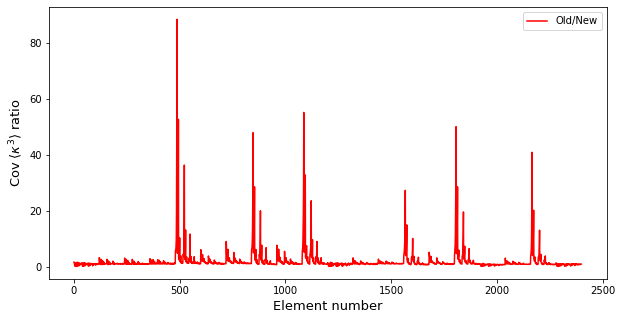

In [8]:
# kp2_all_data.shape
pl.figure(figsize=(10,5))
pl.plot(np.diag(kp3_all_data_cov_orig)/np.diag(kp3_all_data_cov), color='r', label='Old/New')
# pl.plot(kp2_all_data_mean, color='b', label='New')
pl.ylabel(r'Cov $\langle \kappa^3 \rangle$ ratio', size=13)
pl.xlabel(r'Element number', size=13)

pl.legend()
pl.show()



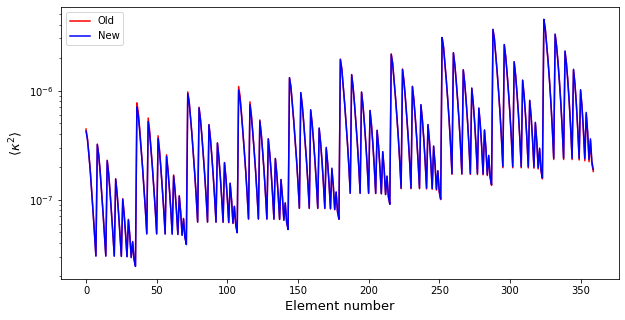

In [9]:
# kp2_all_data.shape
pl.figure(figsize=(10,5))
pl.plot(kp2_all_data_mean_orig, color='r', label='Old')
pl.plot(kp2_all_data_mean, color='b', label='New')
pl.ylabel(r'$\langle \kappa^2 \rangle$', size=13)
pl.xlabel(r'Element number', size=13)
pl.yscale('log')
pl.legend()
pl.show()



In [10]:
kp2_all_data.shape


(221, 360)

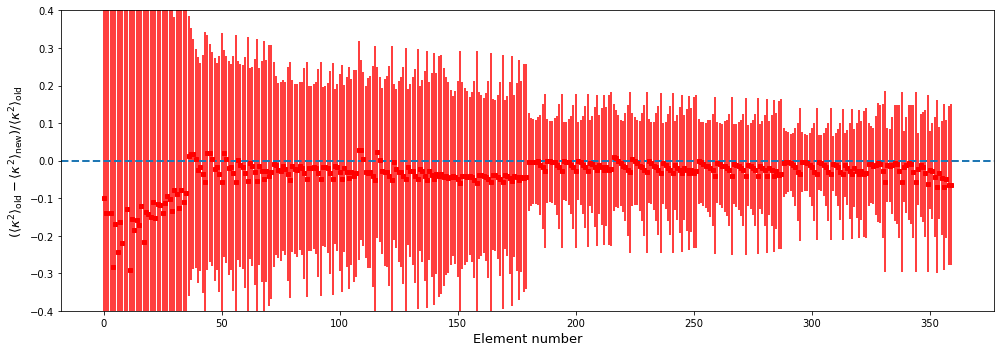

In [12]:
# kp2_all_data.shape
pl.figure(figsize=(14,5))
resid_all = np.zeros((kp2_all_data.shape[1], kp2_all_data.shape[0]))
for ji in range(kp2_all_data_orig.shape[0]):
    resid_all[:,ji] = (kp2_all_data_orig[ji,:] - kp2_all_data[ji,:])/kp2_all_data_orig[ji,:]
pl.errorbar(np.arange(kp2_all_data.shape[1]), np.mean(resid_all, axis=1), yerr=np.std(resid_all, axis=1), color='r', ls='', marker='.')
pl.errorbar(np.arange(kp2_all_data.shape[1]), np.mean(resid_all, axis=1), color='r', ls='', marker='s', ms=4.0)
# pl.plot((kp2_all_data_mean_orig - kp2_all_data_mean)/kp2_all_data_mean_orig, color='r', label='Old')
# pl.plot(kp2_all_data_mean, color='b', label='New')
pl.ylabel(r'$(\langle \kappa^2 \rangle_{\rm old} - \langle \kappa^2 \rangle_{\rm new})/\langle \kappa^2 \rangle_{\rm old}$', size=13)
pl.xlabel(r'Element number', size=13)
pl.axhline(0.0, ls='--', lw=2)
pl.ylim(-0.4, 0.4)
# pl.legend()
pl.tight_layout()
# pl.savefig('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/kp2_resid_new.pdf', bbox_inches='tight')
pl.show()



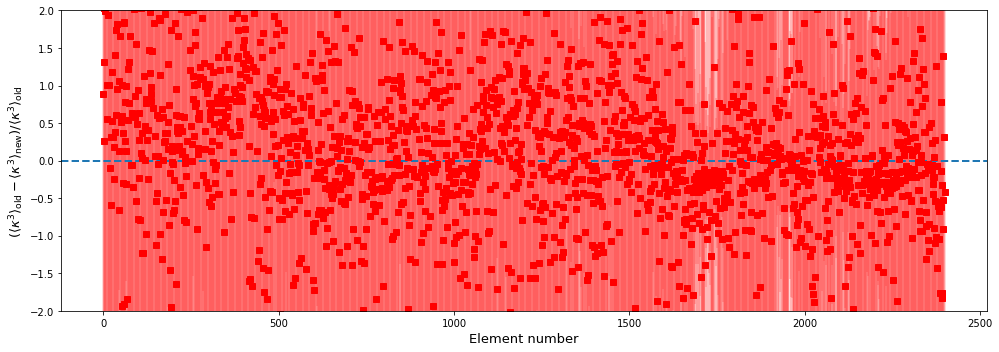

In [14]:
# kp2_all_data.shape
pl.figure(figsize=(14,5))
resid_all = np.zeros((kp3_all_data.shape[1], kp3_all_data.shape[0]))
for ji in range(kp3_all_data_orig.shape[0]):
    resid_all[:,ji] = (kp3_all_data_orig[ji,:] - kp3_all_data[ji,:])/kp3_all_data_orig[ji,:]
pl.errorbar(np.arange(kp3_all_data.shape[1]), np.mean(resid_all, axis=1), yerr=np.std(resid_all, axis=1), alpha=0.2, color='r', ls='', marker='.')
pl.errorbar(np.arange(kp3_all_data.shape[1]), np.mean(resid_all, axis=1), color='r', ls='', marker='s')
# pl.plot((kp2_all_data_mean_orig - kp2_all_data_mean)/kp2_all_data_mean_orig, color='r', label='Old')
# pl.plot(kp2_all_data_mean, color='b', label='New')
pl.ylabel(r'$(\langle \kappa^3 \rangle_{\rm old} - \langle \kappa^3 \rangle_{\rm new})/\langle \kappa^3 \rangle_{\rm old}$', size=13)
pl.xlabel(r'Element number', size=13)
pl.axhline(0.0, ls='--', lw=2)
pl.ylim(-2, 2)
# pl.legend()
pl.tight_layout()
# pl.savefig('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/kp3_resid_new.pdf', bbox_inches='tight')
pl.show()



In [15]:
(np.sqrt(1.5))**3
# 1.22**3



1.8371173070873832

In [21]:
sdir = '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/saveDVs/'
# fname = sdir + 'pkdgrav_fid_wmask_sm5_SCkappa_all_fid'
# fname = sdir + 'theory_full_wmask_sm5_SCkappa_all_fid'
fname = sdir + 'pkdgrav_full_wmask_sm5_SCkappa_all_fid'
df_kappa_all = load_obj(fname)
kappa2_all_fid = df_kappa_all['kp2']
kappa3_all_fid = df_kappa_all['kp3']

kp2_all_fid = []
for jid_kp2 in range(len(id_kp2_unique)):
    jz1, jz2, i, j = id_kp2_unique[jid_kp2]
    kp2_all_fid.append(kappa2_all_fid[jz1, jz2, i, j])
kp2_all_fid = np.array(kp2_all_fid)

kp3_all_fid = []
indsel_uneq = []
indsel_uneq2 = []
for jid_kp3 in range(len(id_kp3_unique)):
    jz1, jz2, jz3, i, j, k = id_kp3_unique[jid_kp3]
    if jz1==0 and jz2==3 and jz3==3:
        indsel_uneq.append(jid_kp3)
    if jz1==0 and jz2==0 and jz3==3:
        indsel_uneq2.append(jid_kp3)
        
    kp3_all_fid.append(kappa3_all_fid[jz1, jz2, jz3, i, j, k])
kp3_all_fid = np.array(kp3_all_fid)






In [26]:
saved = {'kp2_all_fid':kp2_all_fid, 'kp3_all_fid':kp3_all_fid, 'kp3_all_data':kp3_all_data, 'kp2_all_data':kp2_all_data}
pk.dump(saved, open('fid_sim_measurements_cosmogrid_constrained_rot.pk','wb'))






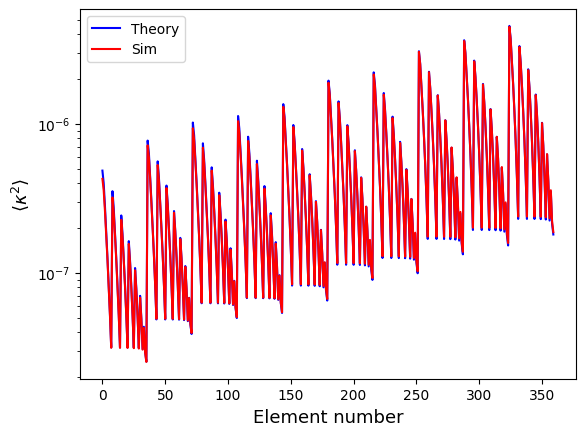

In [22]:
# (kp3_all_fid - kp3_all_data)/kp3_all_fid

# (kp2_all_fid - kp2_all_data)/kp2_all_fid
pl.figure()
pl.plot(kp2_all_fid, label='Theory', color='b')
pl.plot(kp2_all_data_mean, label='Sim', color='r')
pl.yscale('log')
pl.legend()
# pl.ylim(-0.5,0.5)
# pl.ylabel(r'$\Delta \langle \kappa^2 \rangle/ \langle \kappa^2 \rangle_{\rm theory}$', size=13)
pl.ylabel(r'$\langle \kappa^2 \rangle$', size=13)
pl.xlabel(r'Element number', size=13)
# pl.axhline(0.0, ls='--', color='k')
pl.show()



In [23]:
# dfc = np.loadtxt('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/test_bias_values_blv2_mlv1_autowtONLY.txt')
# chi2v = -2.*dfc[:,-3]
# dfc[np.argmin(chi2v),:]




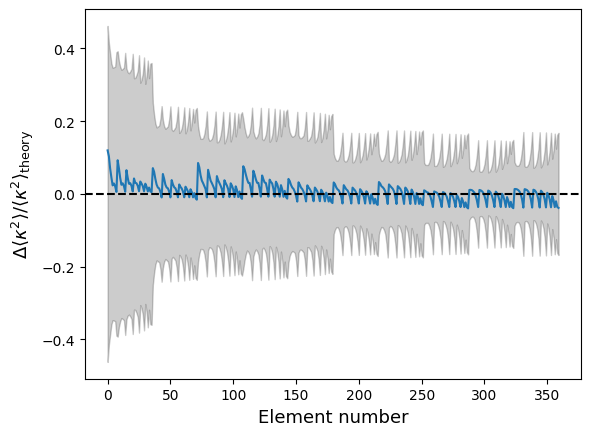

In [24]:
# (kp2_all_fid - kp2_all_data)/kp2_all_fid
pl.figure()
sig_low, sig_high = -1*np.sqrt(np.diag(kp2_all_data_cov))/kp2_all_fid, np.sqrt(np.diag(kp2_all_data_cov))/kp2_all_fid
pl.plot((kp2_all_fid - kp2_all_data_mean)/kp2_all_fid)
pl.fill_between(np.arange(len(sig_low)), sig_low, sig_high, alpha=0.2, color='k')
# pl.ylim(-0.5,0.5)
pl.ylabel(r'$\Delta \langle \kappa^2 \rangle/ \langle \kappa^2 \rangle_{\rm theory}$', size=13)
pl.xlabel(r'Element number', size=13)
pl.axhline(0.0, ls='--', color='k')
# pl.savefig('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/kp2_resid_wtheory.pdf', bbox_inches='tight')
pl.show()




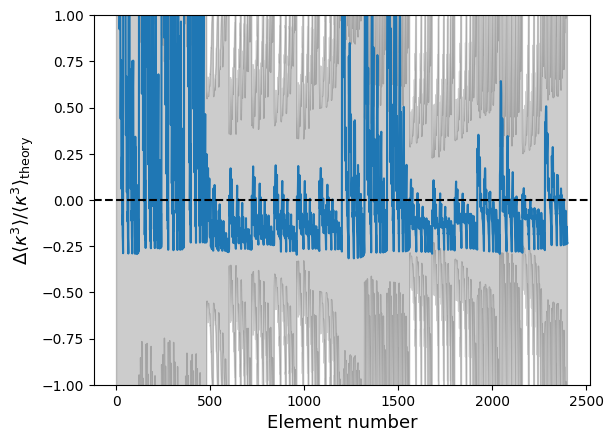

In [25]:
# (kp2_all_fid - kp2_all_data)/kp2_all_fid
fsky = 1.0
pl.figure()
sig_low, sig_high = -1*np.sqrt(np.diag((fsky*fsky)*kp3_all_data_cov))/kp3_all_fid, np.sqrt(np.diag((fsky*fsky)*kp3_all_data_cov))/kp3_all_fid
pl.plot((kp3_all_fid - kp3_all_data_mean)/kp3_all_fid)
pl.fill_between(np.arange(len(sig_low)), sig_low, sig_high, alpha=0.2, color='k')
# pl.plot((kp3_all_fid - kp3_all_data_mean)/kp3_all_data_mean)
pl.ylabel(r'$\Delta \langle \kappa^3 \rangle/ \langle \kappa^3 \rangle_{\rm theory}$', size=13)
pl.xlabel(r'Element number', size=13)
pl.axhline(0.0, ls='--', color='k')
# pl.ylim(-0.8,0.8)
pl.ylim(-1,1)
pl.savefig('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/kp3_resid_wtheory.pdf', bbox_inches='tight')
pl.show()






In [42]:
ldir = '/global/cfs/cdirs/des/mgatti/maps_shivam_mask/'

nsm = 8
nzbins = 4
_, id_kp2_unique, _, id_kp3_unique = save_unique_combs(nsm, nzbins)


kp2_all_data = []
kp3_all_data = []
from tqdm import tqdm
for js in tqdm(range(50)):
    for jr in range(4):

        df = pk.load(open(ldir + 'moments_NEW_grid_fiducialcosmo_SC_k_Om=0.26_s8=0.84num=' + str(js) + 'A_IA=0.00e_IA=0.00rot=' + str(jr) + '.pkl','rb'))   

        kp2_all = []
        for jid_kp2 in range(len(id_kp2_unique)):
            jz1, jz2, i, j = id_kp2_unique[jid_kp2]
            key_jid = str(jz1) + '_' + str(jz2)
            kp2_allsm_jid = df.moments['kEkE'][key_jid]
            kp2_all.append(kp2_allsm_jid[i, j])
        kp2_all_data_jrjs = np.array(kp2_all)
        kp2_all_data.append(kp2_all_data_jrjs)


        kp3_all = []
        for jid_kp3 in (range(len(id_kp3_unique))):
            jz1, jz2, jz3, i, j, k = id_kp3_unique[jid_kp3]
            key_jid = str(jz1) + '_' + str(jz2) + '_' + str(jz3)

            kp3EE_allsm_jid = df.moments['kEkE'][key_jid]

            # EEEdenoise = df.moments["kEkN"][key_jid]
            # kp3_allsm_jid = ((kp3EE_allsm_jid - EEEdenoise - np.transpose(EEEdenoise, [2,1,0]) - np.transpose(EEEdenoise, [1,0,2]) ))
            # EEEdenoise = df.moments["kEkN"][key_jid]
            kp3_allsm_jid = (kp3EE_allsm_jid)

            
            kp3_all.append(kp3_allsm_jid[i, j, k])
        kp3_all_data_jrjs = np.array(kp3_all)
        kp3_all_data.append(kp3_all_data_jrjs)


kp3_all_data = np.vstack(kp3_all_data)
kp2_all_data = np.vstack(kp2_all_data)
print(kp2_all_data.shape)
kp3_all_data_mean = np.mean(kp3_all_data, axis=0)
kp2_all_data_mean = np.mean(kp2_all_data, axis=0)
kp3_all_data_cov = np.cov(kp3_all_data.T)
kp2_all_data_cov = np.cov(kp2_all_data.T)





100%|██████████| 50/50 [00:08<00:00,  6.10it/s]


(200, 360)


In [11]:
sdir = '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/saveDVs/'
fname = sdir + 'pkdgrav_fid_wmask_sm5_SCkappa_all_fid'
# fname = sdir + 'pkdgrav_fid_wmask_sm5_newIAkappa_all_fid'
df_kappa_all = load_obj(fname)
kappa2_all_fid = df_kappa_all['kp2']
kappa3_all_fid = df_kappa_all['kp3']

kp2_all_fid = []
indsel_kp2_eq = []
indsel_kp2_ac = []
for jid_kp2 in range(len(id_kp2_unique)):
    jz1, jz2, i, j = id_kp2_unique[jid_kp2]
    kp2_all_fid.append(kappa2_all_fid[jz1, jz2, i, j])
    
    if (i==j):
        indsel_kp2_eq.append(jid_kp2)
        
    if (j in [6,7]) and (i in [1,2]):
        indsel_kp2_ac.append(jid_kp2)
    
    
kp2_all_fid = np.array(kp2_all_fid)

kp3_all_fid = []
indsel_kp3_eq = []
# indsel_kp3_eq_eq = []
indsel_kp3_ac = []
# indsel_ob = []
# indsel_uneq2 = []
for jid_kp3 in range(len(id_kp3_unique)):
    jz1, jz2, jz3, i, j, k = id_kp3_unique[jid_kp3]
    if (i==j) and (j==k):
        indsel_kp3_eq.append(jid_kp3)
        # if jz1==jz2==jz3
        
    if (k in [6,7]) and (j in [6,7]) and (i in [1,2]):
        indsel_kp3_ac.append(jid_kp3)
        # if jz1==0 and jz2==0 and jz3==3:
    #     indsel_uneq2.append(jid_kp3)
        
    kp3_all_fid.append(kappa3_all_fid[jz1, jz2, jz3, i, j, k])
kp3_all_fid_new = np.array(kp3_all_fid)
kp3_all_fid = np.array(kp3_all_fid)



In [12]:
saved = {'kp2_all_fid':kp2_all_fid, 'kp3_all_fid':kp3_all_fid, 'kp3_all_data':kp3_all_data, 'kp2_all_data':kp2_all_data}
pk.dump(saved, open('fid_sim_measurements_noiseless.pk','wb'))






In [289]:
# sdir = '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/saveDVs/'
# fname = sdir + 'pkdgrav_fid_wmask_sm5_oldIAkappa_all_fid'
# df_kappa_all = load_obj(fname)
# kappa2_all_fid = df_kappa_all['kp2']
# kappa3_all_fid = df_kappa_all['kp3']

# kp2_all_fid = []
# indsel_kp2_eq = []
# indsel_kp2_ac = []
# for jid_kp2 in range(len(id_kp2_unique)):
#     jz1, jz2, i, j = id_kp2_unique[jid_kp2]
#     kp2_all_fid.append(kappa2_all_fid[jz1, jz2, i, j])
    
#     if (i==j):
#         indsel_kp2_eq.append(jid_kp2)
        
#     if (j in [6,7]) and (i in [1,2]):
#         indsel_kp2_ac.append(jid_kp2)
    
    
# kp2_all_fid = np.array(kp2_all_fid)

# kp3_all_fid = []
# indsel_kp3_eq = []
# # indsel_kp3_eq_eq = []
# indsel_kp3_ac = []
# # indsel_ob = []
# # indsel_uneq2 = []
# for jid_kp3 in range(len(id_kp3_unique)):
#     jz1, jz2, jz3, i, j, k = id_kp3_unique[jid_kp3]
#     if (i==j) and (j==k):
#         indsel_kp3_eq.append(jid_kp3)
#         # if jz1==jz2==jz3
        
#     if (k in [6,7]) and (j in [6,7]) and (i in [1,2]):
#         indsel_kp3_ac.append(jid_kp3)
#         # if jz1==0 and jz2==0 and jz3==3:
#     #     indsel_uneq2.append(jid_kp3)
        
#     kp3_all_fid.append(kappa3_all_fid[jz1, jz2, jz3, i, j, k])
# kp3_all_fid_old = np.array(kp3_all_fid)




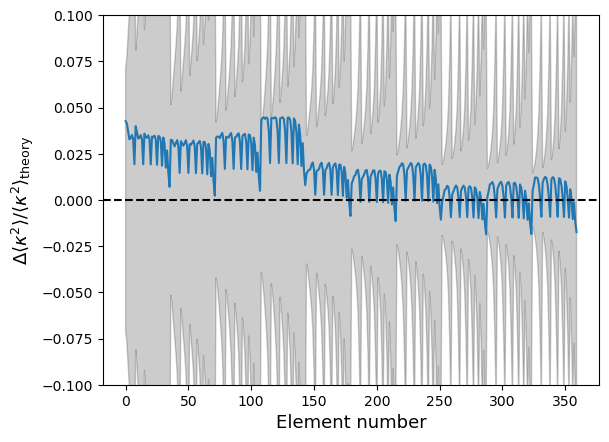

In [7]:
# (kp2_all_fid - kp2_all_data)/kp2_all_fid
pl.figure()
sig_low, sig_high = -1*np.sqrt(np.diag(kp2_all_data_cov))/kp2_all_fid, np.sqrt(np.diag(kp2_all_data_cov))/kp2_all_fid
pl.plot((kp2_all_fid - kp2_all_data_mean)/kp2_all_fid)
pl.fill_between(np.arange(len(sig_low)), sig_low, sig_high, alpha=0.2, color='k')
pl.ylim(-0.1,0.1)
pl.ylabel(r'$\Delta \langle \kappa^2 \rangle/ \langle \kappa^2 \rangle_{\rm theory}$', size=13)
pl.xlabel(r'Element number', size=13)
pl.axhline(0.0, ls='--', color='k')
# pl.savefig('kappa2_GM_mead2020_feedback.pdf')
# pl.savefig('kappa2_GM_halofit_sm5.pdf',bbox_inches='tight')
pl.show()




In [9]:
# # (kp2_all_fid - kp2_all_data)/kp2_all_fid
# fsky = 0.11789
# pl.figure()
# sig_low, sig_high = -1*np.sqrt(np.diag((fsky*fsky)*kp3_all_data_cov))/kp3_all_fid, np.sqrt(np.diag((fsky*fsky)*kp3_all_data_cov))/kp3_all_fid
# pl.plot((kp3_all_fid_new - kp3_all_fid_old)/kp3_all_fid_old)
# pl.fill_between(np.arange(len(sig_low)), sig_low, sig_high, alpha=0.2, color='k')
# # pl.plot((kp3_all_fid - kp3_all_data_mean)/kp3_all_data_mean)
# pl.ylabel(r'$\Delta \langle \kappa^3 \rangle/ \langle \kappa^3 \rangle_{\rm theory}$', size=13)
# pl.xlabel(r'Element number', size=13)
# pl.axhline(0.0, ls='--', color='k')
# pl.ylim(-1.5,1.5)
# # pl.savefig('kappa3_GM_halofit_sm5.pdf',bbox_inches='tight')
# # pl.savefig('kappa3_GM_mead2020_feedback.pdf')
# pl.show()








In [282]:
(kp3_all_fid_new - kp3_all_fid_old)/kp3_all_fid_old


array([1.44560194, 1.34570821, 1.23193442, ..., 0.02888588, 0.02671334,
       0.02620098])

In [275]:
# (kp3_all_fid_new - kp3_all_fid_old)/kp3_all_fid_old


array([0., 0., 0., ..., 0., 0., 0.])

<Figure size 640x480 with 0 Axes>

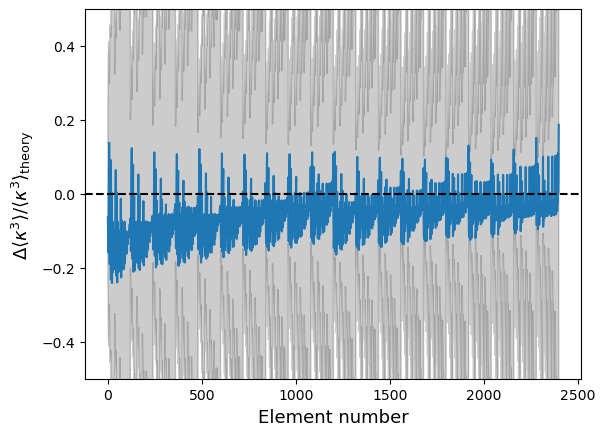

In [10]:
# (kp2_all_fid - kp2_all_data)/kp2_all_fid
fsky = 0.11789
pl.figure()
sig_low, sig_high = -1*np.sqrt(np.diag((fsky*fsky)*kp3_all_data_cov))/kp3_all_fid, np.sqrt(np.diag((fsky*fsky)*kp3_all_data_cov))/kp3_all_fid
pl.plot((kp3_all_fid - (fsky)*kp3_all_data_mean)/kp3_all_fid)
pl.fill_between(np.arange(len(sig_low)), sig_low, sig_high, alpha=0.2, color='k')
# pl.plot((kp3_all_fid - kp3_all_data_mean)/kp3_all_data_mean)
pl.ylabel(r'$\Delta \langle \kappa^3 \rangle/ \langle \kappa^3 \rangle_{\rm theory}$', size=13)
pl.xlabel(r'Element number', size=13)
pl.axhline(0.0, ls='--', color='k')
pl.ylim(-0.5,0.5)
# pl.savefig('kappa3_GM_halofit_sm5.pdf',bbox_inches='tight')
# pl.savefig('kappa3_GM_mead2020_feedback.pdf')
pl.show()








In [204]:
ldir = '/global/cfs/cdirs/des/mgatti/maps_shivam/'

nsm = 8
nzbins = 4
_, id_kp2_unique, _, id_kp3_unique = save_unique_combs(nsm, nzbins)


kp2_all_data = []
kp3_all_data = []
from tqdm import tqdm
for js in tqdm(range(50)):
    for jr in range(4):

        df = pk.load(open(ldir + 'moments_NEW_grid_fiducialcosmo_SC_k_Om=0.26_s8=0.84num=' + str(js) + 'A_IA=0.00e_IA=0.00.pkl','rb'))   

        kp2_all = []
        for jid_kp2 in range(len(id_kp2_unique)):
            jz1, jz2, i, j = id_kp2_unique[jid_kp2]
            key_jid = str(jz1) + '_' + str(jz2)
            kp2_allsm_jid = df.moments['kEkE'][key_jid]
            kp2_all.append(kp2_allsm_jid[i, j])
        kp2_all_data_jrjs = np.array(kp2_all)
        kp2_all_data.append(kp2_all_data_jrjs)


        kp3_all = []
        for jid_kp3 in (range(len(id_kp3_unique))):
            jz1, jz2, jz3, i, j, k = id_kp3_unique[jid_kp3]
            key_jid = str(jz1) + '_' + str(jz2) + '_' + str(jz3)

            kp3EE_allsm_jid = df.moments['kEkE'][key_jid]

            # EEEdenoise = df.moments["kEkN"][key_jid]
            # kp3_allsm_jid = ((kp3EE_allsm_jid - EEEdenoise - np.transpose(EEEdenoise, [2,1,0]) - np.transpose(EEEdenoise, [1,0,2]) ))
            # EEEdenoise = df.moments["kEkN"][key_jid]
            kp3_allsm_jid = (kp3EE_allsm_jid)

            
            kp3_all.append(kp3_allsm_jid[i, j, k])
        kp3_all_data_jrjs = np.array(kp3_all)
        kp3_all_data.append(kp3_all_data_jrjs)


kp3_all_data = np.vstack(kp3_all_data)
kp2_all_data = np.vstack(kp2_all_data)

kp3_all_data_mean = np.mean(kp3_all_data, axis=0)
kp2_all_data_mean = np.mean(kp2_all_data, axis=0)
kp3_all_data_cov = np.cov(kp3_all_data.T)
kp2_all_data_cov = np.cov(kp2_all_data.T)





100%|██████████| 50/50 [00:03<00:00, 13.53it/s]


In [210]:
sdir = '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/saveDVs/'
fname = sdir + 'pkdgrav_fid_nomaskkappa_all_fid'
df_kappa_all = load_obj(fname)
kappa2_all_fid = df_kappa_all['kp2']
kappa3_all_fid = df_kappa_all['kp3']

kp2_all_fid = []
indsel_kp2_eq = []
indsel_kp2_ac = []
for jid_kp2 in range(len(id_kp2_unique)):
    jz1, jz2, i, j = id_kp2_unique[jid_kp2]
    kp2_all_fid.append(kappa2_all_fid[jz1, jz2, i, j])
    
    if (i==j):
        indsel_kp2_eq.append(jid_kp2)
        
    if (j in [6,7]) and (i in [1,2]):
        indsel_kp2_ac.append(jid_kp2)
    
    
kp2_all_fid = np.array(kp2_all_fid)

kp3_all_fid = []
indsel_kp3_eq = []
# indsel_kp3_eq_eq = []
indsel_kp3_ac = []
# indsel_ob = []
# indsel_uneq2 = []
for jid_kp3 in range(len(id_kp3_unique)):
    jz1, jz2, jz3, i, j, k = id_kp3_unique[jid_kp3]
    if (i==j) and (j==k):
        indsel_kp3_eq.append(jid_kp3)
        # if jz1==jz2==jz3
        
    if (k in [6,7]) and (j in [6,7]) and (i in [1,2]):
        indsel_kp3_ac.append(jid_kp3)
        # if jz1==0 and jz2==0 and jz3==3:
    #     indsel_uneq2.append(jid_kp3)
        
    kp3_all_fid.append(kappa3_all_fid[jz1, jz2, jz3, i, j, k])
kp3_all_fid = np.array(kp3_all_fid)




In [211]:
# len(indsel_eq)
# indsel_kp3_eq



In [212]:
# # (kp3_all_fid - kp3_all_data)/kp3_all_fid

# # (kp2_all_fid - kp2_all_data)/kp2_all_fid
# pl.figure()
# pl.plot(kp2_all_fid, label='Theory')
# pl.plot(kp2_all_data_mean, label='Sim')
# pl.yscale('log')
# pl.legend()
# # pl.ylim(-0.5,0.5)
# # pl.ylabel(r'$\Delta \langle \kappa^2 \rangle/ \langle \kappa^2 \rangle_{\rm theory}$', size=13)
# pl.ylabel(r'$\langle \kappa^2 \rangle$', size=13)
# pl.xlabel(r'Element number', size=13)
# # pl.axhline(0.0, ls='--', color='k')
# pl.show()





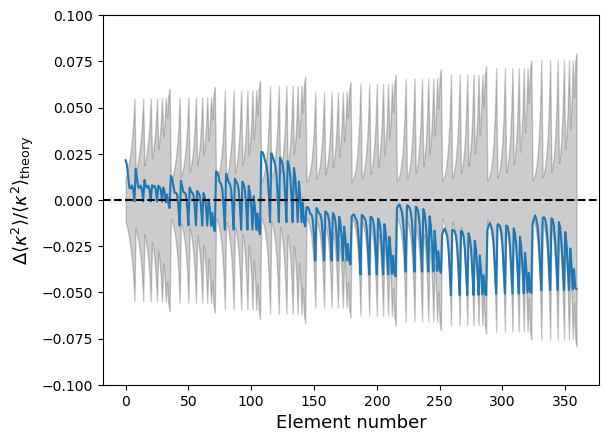

In [213]:
# (kp2_all_fid - kp2_all_data)/kp2_all_fid
pl.figure()
sig_low, sig_high = -1*np.sqrt(np.diag(kp2_all_data_cov))/kp2_all_fid, np.sqrt(np.diag(kp2_all_data_cov))/kp2_all_fid
pl.plot((kp2_all_fid - kp2_all_data_mean)/kp2_all_fid)
pl.fill_between(np.arange(len(sig_low)), sig_low, sig_high, alpha=0.2, color='k')
pl.ylim(-0.1,0.1)
pl.ylabel(r'$\Delta \langle \kappa^2 \rangle/ \langle \kappa^2 \rangle_{\rm theory}$', size=13)
pl.xlabel(r'Element number', size=13)
pl.axhline(0.0, ls='--', color='k')
# pl.savefig('kappa2_GM_mead2020_feedback.pdf')
# pl.savefig('kappa2_GM_halofit.pdf',bbox_inches='tight')
pl.show()






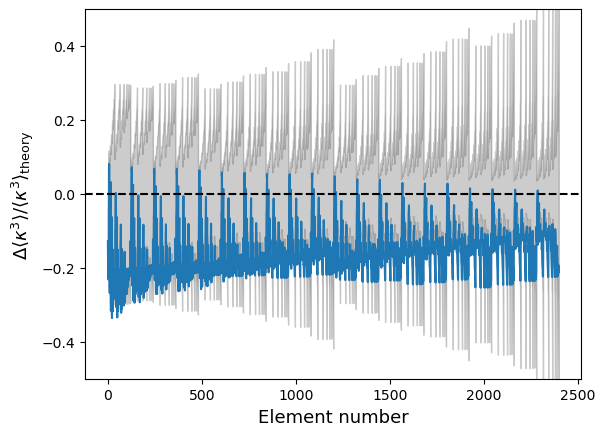

In [215]:
# (kp2_all_fid - kp2_all_data)/kp2_all_fid
fsky = 1.0
pl.figure()
sig_low, sig_high = -1*np.sqrt(np.diag((fsky*fsky)*kp3_all_data_cov))/kp3_all_fid, np.sqrt(np.diag((fsky*fsky)*kp3_all_data_cov))/kp3_all_fid
pl.plot((kp3_all_fid - (fsky)*kp3_all_data_mean)/kp3_all_fid)
pl.fill_between(np.arange(len(sig_low)), sig_low, sig_high, alpha=0.2, color='k')
# pl.plot((kp3_all_fid - kp3_all_data_mean)/kp3_all_data_mean)
pl.ylabel(r'$\Delta \langle \kappa^3 \rangle/ \langle \kappa^3 \rangle_{\rm theory}$', size=13)
pl.xlabel(r'Element number', size=13)
pl.axhline(0.0, ls='--', color='k')
pl.ylim(-0.5,0.5)
# pl.savefig('kappa3_GM_mead2020_feedback.pdf')
pl.show()






In [201]:
indsel = np.where((kp3_all_fid - (fsky)*kp3_all_data_mean)/kp3_all_fid > 0)[0]
# print(indsel)
# print(id_kp3_unique[indsel])
# indsel
for ji in indsel:
    print(id_kp3_unique[ji])


(0, 0, 0, 0, 0, 6)
(0, 0, 0, 0, 0, 7)
(0, 0, 0, 0, 1, 7)
(0, 0, 0, 1, 1, 7)
(0, 0, 1, 0, 0, 6)
(0, 0, 1, 0, 0, 7)
(0, 0, 1, 0, 1, 7)
(0, 0, 1, 1, 1, 7)
(0, 0, 2, 0, 0, 6)
(0, 0, 2, 0, 0, 7)
(0, 0, 2, 0, 1, 7)
(0, 0, 2, 1, 1, 7)
(0, 0, 3, 0, 0, 6)
(0, 0, 3, 0, 0, 7)
(0, 0, 3, 0, 1, 7)
(0, 0, 3, 1, 1, 7)
(0, 1, 1, 0, 0, 6)
(0, 1, 1, 0, 0, 7)
(0, 1, 1, 0, 1, 7)
(0, 1, 1, 1, 1, 7)
(0, 1, 2, 0, 0, 6)
(0, 1, 2, 0, 0, 7)
(0, 1, 2, 0, 1, 7)
(0, 1, 2, 1, 1, 7)
(0, 1, 3, 0, 0, 6)
(0, 1, 3, 0, 0, 7)
(0, 1, 3, 0, 1, 7)
(0, 1, 3, 1, 1, 7)
(0, 2, 2, 0, 0, 6)
(0, 2, 2, 0, 0, 7)
(0, 2, 2, 0, 1, 7)
(0, 2, 2, 1, 1, 7)
(0, 2, 3, 0, 0, 6)
(0, 2, 3, 0, 0, 7)
(0, 2, 3, 0, 1, 7)
(0, 2, 3, 1, 1, 7)
(0, 3, 3, 0, 0, 6)
(0, 3, 3, 0, 0, 7)
(0, 3, 3, 0, 1, 7)
(0, 3, 3, 1, 1, 7)
(1, 1, 1, 0, 0, 6)
(1, 1, 1, 0, 0, 7)
(1, 1, 1, 0, 1, 7)
(1, 1, 2, 0, 0, 6)
(1, 1, 2, 0, 0, 7)
(1, 1, 2, 0, 1, 7)
(1, 1, 3, 0, 0, 6)
(1, 1, 3, 0, 0, 7)
(1, 1, 3, 0, 1, 7)
(1, 2, 2, 0, 0, 6)
(1, 2, 2, 0, 0, 7)
(1, 2, 2, 0, 1, 7)
(1, 2, 3, 0,

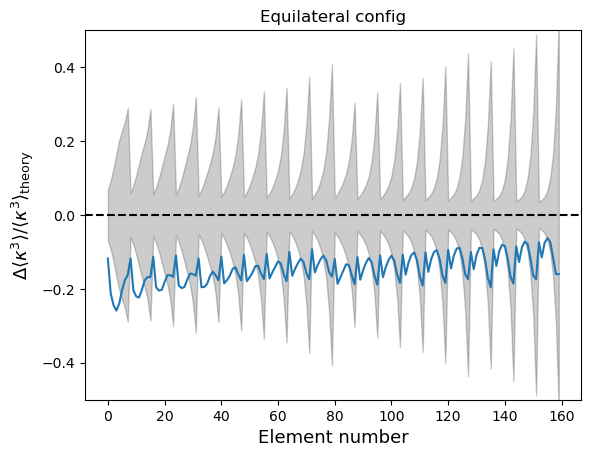

In [209]:
# (kp2_all_fid - kp2_all_data)/kp2_all_fid
fsky = 1.0
pl.figure()
sig_low, sig_high = -1*np.sqrt(np.diag((fsky*fsky)*kp3_all_data_cov))/kp3_all_fid, np.sqrt(np.diag((fsky*fsky)*kp3_all_data_cov))/kp3_all_fid
pl.plot((kp3_all_fid[indsel_kp3_eq] - (fsky)*kp3_all_data_mean[indsel_kp3_eq])/kp3_all_fid[indsel_kp3_eq])
pl.fill_between(np.arange(len(sig_low[indsel_kp3_eq])), sig_low[indsel_kp3_eq], sig_high[indsel_kp3_eq], alpha=0.2, color='k')
# pl.plot((kp3_all_fid - kp3_all_data_mean)/kp3_all_data_mean)
pl.ylabel(r'$\Delta \langle \kappa^3 \rangle/ \langle \kappa^3 \rangle_{\rm theory}$', size=13)
pl.xlabel(r'Element number', size=13)
pl.axhline(0.0, ls='--', color='k')
pl.ylim(-0.5,0.5)
pl.title('Equilateral config')
# pl.savefig('kappa3_GM_halofit_equilateral.pdf')
pl.show()








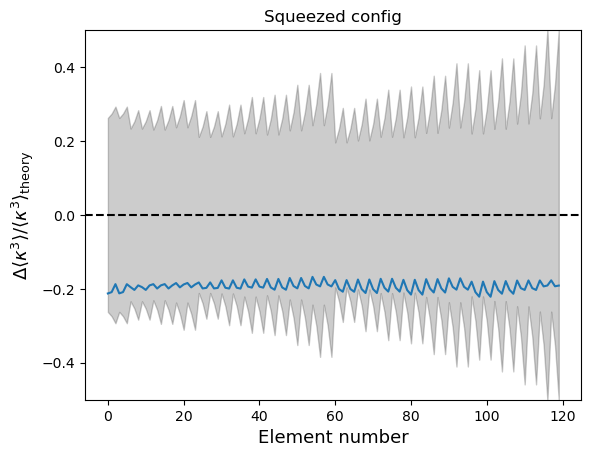

In [173]:
# (kp2_all_fid - kp2_all_data)/kp2_all_fid
fsky = 1.0
pl.figure()
sig_low, sig_high = -1*np.sqrt(np.diag((fsky*fsky)*kp3_all_data_cov))/kp3_all_fid, np.sqrt(np.diag((fsky*fsky)*kp3_all_data_cov))/kp3_all_fid
pl.plot((kp3_all_fid[indsel_kp3_ac] - (fsky)*kp3_all_data_mean[indsel_kp3_ac])/kp3_all_fid[indsel_kp3_ac])
pl.fill_between(np.arange(len(sig_low[indsel_kp3_ac])), sig_low[indsel_kp3_ac], sig_high[indsel_kp3_ac], alpha=0.2, color='k')
# pl.plot((kp3_all_fid - kp3_all_data_mean)/kp3_all_data_mean)
pl.ylabel(r'$\Delta \langle \kappa^3 \rangle/ \langle \kappa^3 \rangle_{\rm theory}$', size=13)
pl.xlabel(r'Element number', size=13)
pl.axhline(0.0, ls='--', color='k')
pl.ylim(-0.5,0.5)
pl.title('Squeezed config')
pl.savefig('kappa3_GM_halofit_squeezed.pdf')
pl.show()








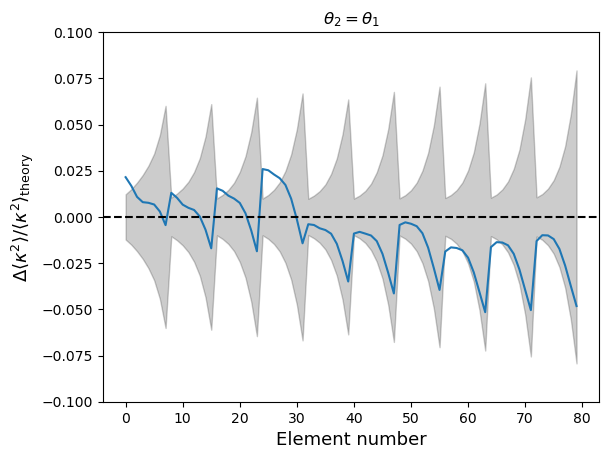

In [214]:
# (kp2_all_fid - kp2_all_data)/kp2_all_fid
pl.figure()
sig_low, sig_high = -1*np.sqrt(np.diag(kp2_all_data_cov))/kp2_all_fid, np.sqrt(np.diag(kp2_all_data_cov))/kp2_all_fid
pl.plot((kp2_all_fid[indsel_kp2_eq] - kp2_all_data_mean[indsel_kp2_eq])/kp2_all_fid[indsel_kp2_eq])
pl.fill_between(np.arange(len(sig_low[indsel_kp2_eq])), sig_low[indsel_kp2_eq], sig_high[indsel_kp2_eq], alpha=0.2, color='k')
pl.ylim(-0.1,0.1)
pl.ylabel(r'$\Delta \langle \kappa^2 \rangle/ \langle \kappa^2 \rangle_{\rm theory}$', size=13)
pl.xlabel(r'Element number', size=13)
pl.axhline(0.0, ls='--', color='k')
# pl.title('Equal angles')
pl.title(r'$\theta_2 = \theta_1$')
pl.savefig('kappa2_GM_halofit_equal.pdf')
# pl.savefig('kappa2_GM_mead2020_feedback.pdf')
# pl.savefig('kappa2_SC_halofit.pdf')
pl.show()






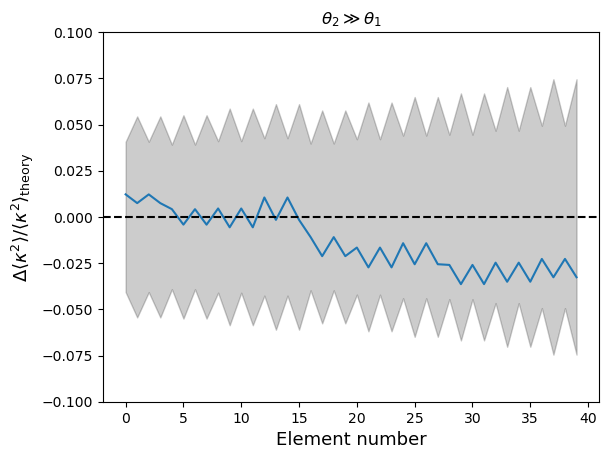

In [167]:
# (kp2_all_fid - kp2_all_data)/kp2_all_fid
pl.figure()
sig_low, sig_high = -1*np.sqrt(np.diag(kp2_all_data_cov))/kp2_all_fid, np.sqrt(np.diag(kp2_all_data_cov))/kp2_all_fid
pl.plot((kp2_all_fid[indsel_kp2_ac] - kp2_all_data_mean[indsel_kp2_ac])/kp2_all_fid[indsel_kp2_ac])
pl.fill_between(np.arange(len(sig_low[indsel_kp2_ac])), sig_low[indsel_kp2_ac], sig_high[indsel_kp2_ac], alpha=0.2, color='k')
pl.ylim(-0.1,0.1)
pl.ylabel(r'$\Delta \langle \kappa^2 \rangle/ \langle \kappa^2 \rangle_{\rm theory}$', size=13)
pl.xlabel(r'Element number', size=13)
pl.axhline(0.0, ls='--', color='k')
pl.title(r'$\theta_2 \gg \theta_1$')
pl.savefig('kappa2_GM_halofit_different.pdf')
# pl.savefig('kappa2_GM_mead2020_feedback.pdf')
# pl.savefig('kappa2_SC_halofit.pdf')
pl.show()






In [216]:
z_ehu = np.loadtxt('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/demo8/matter_power_no_bao/z.txt')
kh_ehu = np.loadtxt('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/demo8/matter_power_no_bao/k_h.txt')
df_ehu = np.loadtxt('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/demo8/matter_power_no_bao/p_k.txt')



In [217]:
z_camb = np.loadtxt('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/demo8/matter_power_lin/z.txt')
kh_camb = np.loadtxt('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/demo8/matter_power_lin/k_h.txt')
df_camb = np.loadtxt('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/output/demo8/matter_power_lin/p_k.txt')



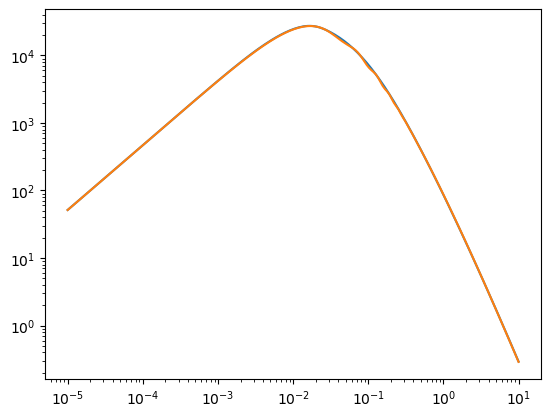

In [225]:
# z_ehu
# df_ehu.shape
pk_ehu = df_ehu[0,:]
pk_camb = df_camb[0,:]
pk_ehu_interp = interpolate.interp1d(np.log(kh_ehu), np.log(pk_ehu))
pk_ehu_kval = np.exp(pk_ehu_interp(np.log(kh_camb)))
pl.figure()
pl.plot(kh_camb, pk_ehu_kval)
pl.plot(kh_camb, pk_camb)
pl.xscale('log')
pl.yscale('log')
pl.show()


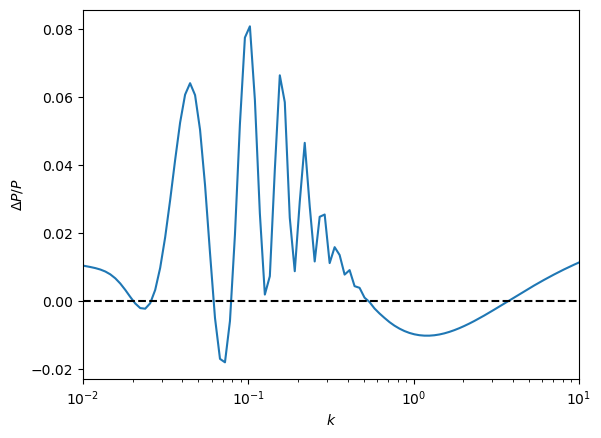

In [231]:
pl.figure()
pl.plot(kh_camb, (pk_ehu_kval - pk_camb)/pk_camb)
# pl.plot(kh_camb, pk_camb)
pl.xscale('log')
pl.xlim(0.01, 10)
pl.ylabel(r'$\Delta P/P$')
pl.xlabel(r'$k$')
pl.axhline(0.0, color='k', ls='--')
# pl.yscale('log')
pl.show()




In [221]:
kh_ehu.shape


(800,)